# OMX Stockholm Large Cap vs Small Cap
This notebook replicates your script as a set of clear, runnable notebook cells.

Notes on small, practical fixes included below:
- `START_DATE` is set to `2014-01-01` (zero padded day) to avoid date parsing surprises.
- Monthly resampling uses `"M"` (month-end) which is the standard alias in pandas.
- The rolling optimal-weight plot is produced per horizon, so it does not accidentally only plot the last horizon.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Parameters
Set the sample period here.


In [2]:
START_DATE = "2014-01-01"
END_DATE = "2024-12-31"

## Load raw data
Update the file paths if your project structure is different.


In [3]:
large_cap = pd.read_csv("data/OMX Stockholm Large Cap PI Historical Data.csv")
small_cap = pd.read_csv("data/OMX Stockholm Small Cap Historical Data.csv")
risk_free = pd.read_csv("data/rf.csv", sep=";")

display(large_cap.head(), small_cap.head(), risk_free.head())


,Date,Price,Open,High,Low,Vol.,Change %
0,10/01/2025,280.27,278.78,280.58,277.93,NaN,0.43%
1,09/30/2025,279.08,277.68,279.08,276.70,NaN,0.41%
2,09/29/2025,277.94,278.09,278.82,276.81,NaN,0.33%
3,09/28/2025,277.02,276.43,277.02,277.02,NaN,0.00%
4,09/26/2025,277.02,276.43,277.64,275.01,NaN,0.68%


,Date,Price,Open,High,Low,Vol.,Change %
0,12/15/2025,"1,189.59","1,188.97","1,195.75","1,188.51",NaN,0.21%
1,12/12/2025,"1,187.09","1,184.55","1,195.54","1,182.88",NaN,0.33%
2,12/11/2025,"1,183.16","1,170.11","1,186.50","1,168.23",NaN,1.49%
3,12/10/2025,"1,165.80","1,170.44","1,172.83","1,163.87",NaN,-0.26%
4,12/09/2025,"1,168.79","1,165.61","1,171.93","1,165.61",NaN,0.31%


,Date,Group,Series,Value
0,30/07/2013,Swedish Treasury Bills (SE TB),SE TB 1 Month,"1,00"
1,31/07/2013,Swedish Treasury Bills (SE TB),SE TB 1 Month,"0,92"
2,01/08/2013,Swedish Treasury Bills (SE TB),SE TB 1 Month,"1,00"
3,02/08/2013,Swedish Treasury Bills (SE TB),SE TB 1 Month,"1,00"
4,03/08/2013,Swedish Treasury Bills (SE TB),SE TB 1 Month,NaN


## Parse dates


In [4]:
large_cap["Date"] = pd.to_datetime(large_cap["Date"])
small_cap["Date"] = pd.to_datetime(small_cap["Date"])
risk_free["Date"] = pd.to_datetime(risk_free["Date"], dayfirst=True)


## Keep only relevant columns


In [5]:
large_cap = large_cap[["Date", "Price"]]
small_cap = small_cap[["Date", "Price"]]
risk_free = risk_free[["Date", "Value"]]


## Convert prices and rates to numeric


In [6]:
large_cap["Price"] = (
    large_cap["Price"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

small_cap["Price"] = (
    small_cap["Price"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

risk_free["Value"] = (
    risk_free["Value"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)


## Sort data so oldest observation comes first


In [7]:
large_cap = large_cap.sort_values("Date")
small_cap = small_cap.sort_values("Date")
risk_free = risk_free.sort_values("Date")


## 6. Set Date as index


In [8]:
large_cap = large_cap.set_index("Date")
small_cap = small_cap.set_index("Date")
risk_free = risk_free.set_index("Date")


## Convert daily data to monthly data (month-end)


In [10]:
large_cap_monthly = large_cap.resample("ME").last()
small_cap_monthly = small_cap.resample("ME").last()

# Use nearest previous observed risk free rate
risk_free_monthly = risk_free.resample("ME").ffill()

display(large_cap_monthly.head(), small_cap_monthly.head(), risk_free_monthly.head())


,Price
Date,
2013-07-31,118.28
2013-08-31,116.59
2013-09-30,120.81
2013-10-31,122.84
2013-11-30,125.58


,Price
Date,
2013-07-31,307.88
2013-08-31,330.94
2013-09-30,344.16
2013-10-31,356.01
2013-11-30,371.38


,Value
Date,
2013-07-31,0.92
2013-08-31,NaN
2013-09-30,1.00
2013-10-31,1.00
2013-11-30,NaN


## 8. Combine all series and apply sample filter


In [11]:
data = pd.concat(
    [large_cap_monthly, small_cap_monthly, risk_free_monthly],
    axis=1,
    join="inner"
)

data.columns = ["LargeCap", "SmallCap", "RiskFree"]

data = data.loc[START_DATE:END_DATE]
display(data.head(), data.tail())


,LargeCap,SmallCap,RiskFree
Date,,,
2014-01-31,125.86,389.24,0.771
2014-02-28,133.43,418.28,0.771
2014-03-31,132.95,403.47,0.749
2014-04-30,133.62,411.17,0.745
2014-05-31,137.42,419.06,NaN


,LargeCap,SmallCap,RiskFree
Date,,,
2024-08-31,284.92,1235.20,3.533
2024-09-30,289.17,1128.35,3.193
2024-10-31,276.60,1105.99,3.019
2024-11-30,274.53,1072.85,2.956
2024-12-31,270.92,1070.35,2.582


## Risk-free monthly return and log returns


In [12]:
# Exact monthly risk free return from annualized percentage rate
data["RiskFree_ret"] = (1 + data["RiskFree"] / 100) ** (1 / 12) - 1

# Monthly log returns
returns = np.log(
    data[["LargeCap", "SmallCap"]] / data[["LargeCap", "SmallCap"]].shift(1)
)

returns.columns = ["LargeCap_ret", "SmallCap_ret"]
returns["RiskFree_ret"] = data["RiskFree_ret"]

returns["LargeCap_excess"] = returns["LargeCap_ret"] - returns["RiskFree_ret"]
returns["SmallCap_excess"] = returns["SmallCap_ret"] - returns["RiskFree_ret"]

returns = returns.dropna()

returns.head()


,LargeCap_ret,SmallCap_ret,RiskFree_ret,LargeCap_excess,SmallCap_excess
Date,,,,,
2014-02-28,0.058407,0.071955,0.000640,0.057767,0.071315
2014-03-31,-0.003604,-0.036049,0.000622,-0.004226,-0.036671
2014-04-30,0.005027,0.018905,0.000619,0.004408,0.018286
2014-06-30,-0.016065,-0.008628,0.000579,-0.016644,-0.009207
2014-07-31,-0.004818,0.002740,0.000206,-0.005025,0.002534


## Summary stats: mean, volatility, correlation, Sharpe


In [13]:
mean_returns_monthly = returns[["LargeCap_ret", "SmallCap_ret"]].mean()
volatility_monthly = returns[["LargeCap_ret", "SmallCap_ret"]].std()

mean_returns_annual = 12 * mean_returns_monthly
volatility_annual = np.sqrt(12) * volatility_monthly

correlation = returns["LargeCap_ret"].corr(returns["SmallCap_ret"])
print(f"Correlation between Large Cap and Small Cap returns: {correlation:.4f}")

mean_excess = returns[["LargeCap_excess", "SmallCap_excess"]].mean()
volatility_for_sharpe = returns[["LargeCap_ret", "SmallCap_ret"]].std()
volatility_for_sharpe.index = mean_excess.index

sharpe_monthly = mean_excess / volatility_for_sharpe
sharpe_annual = sharpe_monthly * np.sqrt(12)

summary = pd.DataFrame({
    "Mean (monthly)": mean_returns_monthly,
    "Volatility (monthly)": volatility_monthly,
    "Mean (annual)": mean_returns_annual,
    "Volatility (annual)": volatility_annual,
})
summary["Sharpe (annual)"] = sharpe_annual.values
summary


Correlation between Large Cap and Small Cap returns: 0.7783


,Mean (monthly),Volatility (monthly),Mean (annual),Volatility (annual),Sharpe (annual)
LargeCap_ret,0.003904,0.045579,0.046846,0.157890,0.266324
SmallCap_ret,0.005652,0.053751,0.067827,0.186197,0.338520


## 11. Portfolios over a weight grid
Weights are the SmallCap allocation in steps of 10%.


In [14]:
weights = np.arange(0, 1.1, 0.1)

portfolio_returns = {}
for w_small in weights:
    w_large = 1 - w_small
    portfolio_returns[f"SmallCap_{int(w_small * 100)}"] = (
        w_large * returns["LargeCap_ret"] +
        w_small * returns["SmallCap_ret"]
    )

portfolio_returns = pd.DataFrame(portfolio_returns)

portfolio_excess = portfolio_returns.sub(returns["RiskFree_ret"], axis=0)

portfolio_mean = portfolio_returns.mean()
portfolio_vol = portfolio_returns.std()

portfolio_mean_annual = 12 * portfolio_mean
portfolio_vol_annual = np.sqrt(12) * portfolio_vol

portfolio_sharpe = (portfolio_excess.mean() / portfolio_returns.std()) * np.sqrt(12)


## 12. Portfolio summary table


In [15]:
portfolio_labels = [f"S{w:.1f} L{1 - w:.1f}" for w in weights]

portfolio_summary = pd.DataFrame({
    "Portfolio Weights": portfolio_labels,
    "Mean return (annual)": portfolio_mean_annual.values,
    "Volatility (annual)": portfolio_vol_annual.values,
    "Sharpe ratio": portfolio_sharpe.values
})

print("Returns shape:", returns.shape)
portfolio_summary


Returns shape: (123, 5)


,Portfolio Weights,Mean return (annual),Volatility (annual),Sharpe ratio
0,S0.0 L1.0,0.046846,0.157890,0.266324
1,S0.1 L0.9,0.048944,0.157029,0.281147
2,S0.2 L0.8,0.051042,0.157046,0.294476
3,S0.3 L0.7,0.053140,0.157942,0.306090
4,S0.4 L0.6,0.055238,0.159702,0.315855
5,S0.5 L0.5,0.057336,0.162297,0.323732
6,S0.6 L0.4,0.059435,0.165688,0.329769
7,S0.7 L0.3,0.061533,0.169829,0.334084
8,S0.8 L0.2,0.063631,0.174664,0.336848
9,S0.9 L0.1,0.065729,0.180139,0.338257


## 13. Cumulative log returns for selected portfolios


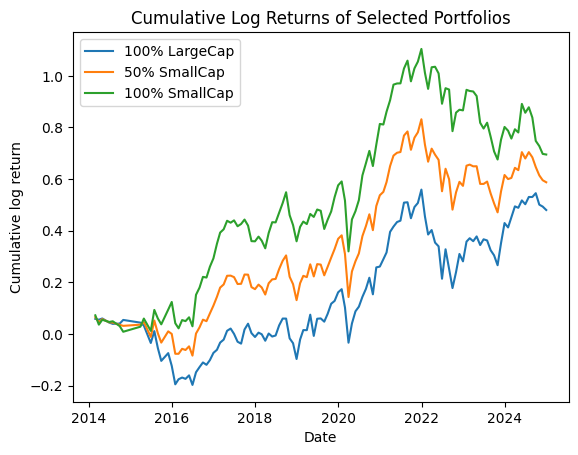

In [16]:
selected_portfolios = {
    "100% LargeCap": portfolio_returns["SmallCap_0"],
    "50% SmallCap": portfolio_returns["SmallCap_50"],
    "100% SmallCap": portfolio_returns["SmallCap_100"],
}

cumulative_selected = pd.DataFrame(selected_portfolios).cumsum()

plt.figure()
for col in cumulative_selected.columns:
    plt.plot(cumulative_selected.index, cumulative_selected[col], label=col)

plt.xlabel("Date")
plt.ylabel("Cumulative log return")
plt.title("Cumulative Log Returns of Selected Portfolios")
plt.legend()
plt.show()


## 14. Rolling-window analysis: best Sharpe weight by horizon
Horizons are defined in months.


In [17]:
HORIZONS_MONTHS = {
    "1Y": 12,
    "3Y": 36,
    "5Y": 60,
}

port_ret = portfolio_returns.copy()
rf_series = returns["RiskFree_ret"].copy()

all_cols = [f"SmallCap_{int(w * 100)}" for w in weights]
all_weights = pd.Index(np.round(weights, 1), name="BestSmallCapWeight")

def sharpe_annual_from_window(port_window: pd.DataFrame, rf_window: pd.Series) -> pd.Series:
    excess = port_window.sub(rf_window, axis=0)
    mu_excess = excess.mean()
    sigma = port_window.std()
    return (mu_excess / sigma) * np.sqrt(12)

rolling_results = {}
rolling_summaries = {}

for horizon_name, window_len in HORIZONS_MONTHS.items():
    print("Horizon:", horizon_name, "window_len:", window_len, "months available:", len(port_ret))

    if len(port_ret) < window_len:
        print(f"Not enough data for horizon {horizon_name} ({window_len} months).")
        continue

    rows = []
    sharpe_rows = []

    for start_i in range(0, len(port_ret) - window_len + 1):
        end_i = start_i + window_len

        window_port_all = port_ret.iloc[start_i:end_i][all_cols]
        window_rf = rf_series.iloc[start_i:end_i]

        sharpe_series_all = sharpe_annual_from_window(window_port_all, window_rf)
        sharpe_rows.append(sharpe_series_all)

        best_col = sharpe_series_all.idxmax()
        best_sharpe = float(sharpe_series_all.loc[best_col])
        best_small_weight = int(best_col.split("_")[1]) / 100.0

        rows.append({
            "WindowStart": window_port_all.index[0],
            "WindowEnd": window_port_all.index[-1],
            "BestPortfolio": best_col,
            "BestSmallCapWeight": best_small_weight,
            "BestSharpeAnnual": best_sharpe,
        })

    rolling_df = pd.DataFrame(rows)
    rolling_results[horizon_name] = rolling_df

    sharpe_by_window = pd.DataFrame(sharpe_rows)
    mean_sharpe_series = sharpe_by_window.mean()
    mean_sharpe_by_weight = {
        int(c.split("_")[1]) / 100.0: float(mean_sharpe_series[c])
        for c in mean_sharpe_series.index
    }

    freq = (
        rolling_df["BestSmallCapWeight"]
        .value_counts()
        .sort_index()
        .rename("Count")
        .to_frame()
    )
    freq = freq.reindex(all_weights, fill_value=0)
    freq["Share"] = freq["Count"] / freq["Count"].sum()
    freq["MeanSharpe"] = [mean_sharpe_by_weight[float(w)] for w in all_weights]

    freq = freq.sort_values("MeanSharpe", ascending=False)
    freq.index = [f"S{w:.1f} L{1 - w:.1f}" for w in freq.index]
    freq.index.name = "Portfolio Weights"

    rolling_summaries[horizon_name] = freq

    print("\n" + "=" * 60)
    print(f"Rolling-window results: {horizon_name} ({window_len} months)")
    print(f"Number of windows: {len(rolling_df)}")
    display(freq)


Horizon: 1Y window_len: 12 months available: 123

Rolling-window results: 1Y (12 months)
Number of windows: 112


,Count,Share,MeanSharpe
Portfolio Weights,,,
S0.9 L0.1,4,0.035714,0.574545
S1.0 L0.0,53,0.473214,0.573820
S0.8 L0.2,4,0.035714,0.573117
S0.7 L0.3,2,0.017857,0.569041
S0.6 L0.4,4,0.035714,0.561869
S0.5 L0.5,3,0.026786,0.551245
S0.4 L0.6,2,0.017857,0.536926
S0.3 L0.7,1,0.008929,0.518775
S0.2 L0.8,2,0.017857,0.496711


Horizon: 3Y window_len: 36 months available: 123

Rolling-window results: 3Y (36 months)
Number of windows: 88


,Count,Share,MeanSharpe
Portfolio Weights,,,
S1.0 L0.0,44,0.500000,0.536162
S0.9 L0.1,2,0.022727,0.530114
S0.8 L0.2,1,0.011364,0.521859
S0.7 L0.3,3,0.034091,0.511100
S0.6 L0.4,3,0.034091,0.497579
S0.5 L0.5,4,0.045455,0.481120
S0.4 L0.6,4,0.045455,0.461660
S0.3 L0.7,3,0.034091,0.439277
S0.2 L0.8,2,0.022727,0.414211


Horizon: 5Y window_len: 60 months available: 123

Rolling-window results: 5Y (60 months)
Number of windows: 64


,Count,Share,MeanSharpe
Portfolio Weights,,,
S1.0 L0.0,35,0.546875,0.559381
S0.9 L0.1,2,0.031250,0.555772
S0.8 L0.2,3,0.046875,0.550350
S0.7 L0.3,4,0.062500,0.542877
S0.6 L0.4,0,0.000000,0.533144
S0.5 L0.5,0,0.000000,0.520985
S0.4 L0.6,1,0.015625,0.506307
S0.3 L0.7,1,0.015625,0.489099
S0.2 L0.8,0,0.000000,0.469449


### Optional: plot how the optimal weight evolves over time (per horizon)


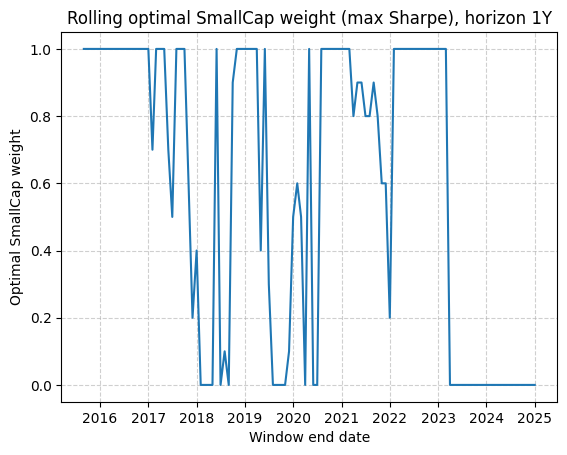

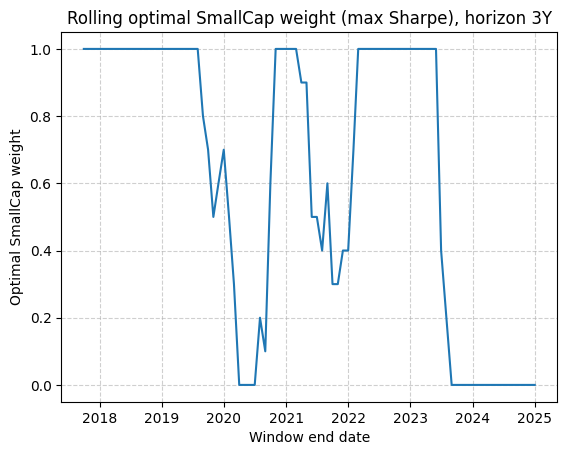

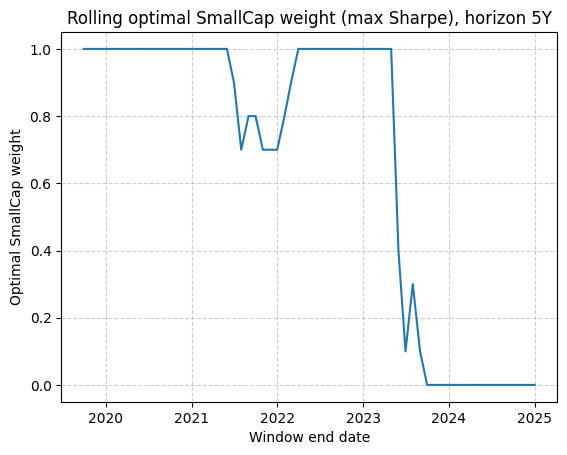

In [18]:
for horizon_name, rolling_df in rolling_results.items():
    plt.figure()
    plt.plot(rolling_df["WindowEnd"], rolling_df["BestSmallCapWeight"])
    plt.xlabel("Window end date")
    plt.ylabel("Optimal SmallCap weight")
    plt.title(f"Rolling optimal SmallCap weight (max Sharpe), horizon {horizon_name}")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


## 15. Max Drawdown (MDD) for each portfolio
Uses monthly log returns in `portfolio_returns`.


In [19]:
def max_drawdown_with_dates_from_log_returns(r_log: pd.Series):
    """
    Computes max drawdown and the dates of the peak and trough.
    Returns:
        mdd (float): negative number, e.g. -0.35
        peak_date (Timestamp)
        trough_date (Timestamp)
    """
    wealth = np.exp(r_log.cumsum())
    peak = wealth.cummax()
    drawdown = wealth / peak - 1.0

    trough_date = drawdown.idxmin()
    peak_date = wealth.loc[:trough_date].idxmax()

    mdd = float(drawdown.loc[trough_date])
    return mdd, peak_date, trough_date

rows = []
for col in portfolio_returns.columns:
    mdd, peak_date, trough_date = max_drawdown_with_dates_from_log_returns(portfolio_returns[col])
    w = int(col.split("_")[1]) / 100.0
    rows.append({
        "Portfolio Weights": f"S{w:.1f} L{1 - w:.1f}",
        "Max Drawdown": mdd,
        "Peak Date": peak_date,
        "Trough Date": trough_date,
    })

mdd_table = pd.DataFrame(rows)

mdd_table["Drawdown Length (months)"] = (
    (mdd_table["Trough Date"].dt.to_period("M") - mdd_table["Peak Date"].dt.to_period("M"))
    .apply(lambda x: x.n)
)

mdd_table = mdd_table.sort_values("Max Drawdown", ascending=False).reset_index(drop=True)

mdd_table


,Portfolio Weights,Max Drawdown,Peak Date,Trough Date,Drawdown Length (months)
0,S0.4 L0.6,-0.299900,2021-12-31,2022-09-30,9
1,S0.5 L0.5,-0.302933,2021-12-31,2023-10-31,22
2,S0.3 L0.7,-0.304299,2021-12-31,2022-09-30,9
3,S0.2 L0.8,-0.308669,2021-12-31,2022-09-30,9
4,S0.6 L0.4,-0.312309,2021-12-31,2023-10-31,22
5,S0.1 L0.9,-0.313012,2021-12-31,2022-09-30,9
6,S0.0 L1.0,-0.317328,2021-12-31,2022-09-30,9
7,S0.7 L0.3,-0.321559,2021-12-31,2023-10-31,22
8,S0.8 L0.2,-0.330685,2021-12-31,2023-10-31,22
9,S0.9 L0.1,-0.339687,2021-12-31,2023-10-31,22
